In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

# Instructions
Using a dataset of your choice, select an outcome variable and then pick four or five other variables (one to two categorical, three to four continuous) to act as the basis for features. Explore the variables using the univariate and bivariate methods you've learned so far.

Next, based on what you learned via your data exploration, create ten new features. Explain the reasoning behind each one.

Finally, use filtering methods to select the five best features and justify your choices.

# Introduction
This dataset from Kaggle (https://www.kaggle.com/yannisp/uber-pickups-enriched) is a record of uber rides in NYC boroughs during 2015.  Each row represents one hour of time in one borough and includes columns for the hour and date, the number of uber pickups, a variety of weather conditions (wind speed, visibility, temperature, etc), and a binary Y or N for whether the day was a US holiday.  

# Cleaning

In [3]:
uber_df = pd.read_csv("uber_nyc_enriched.csv")
uber_df.dropna(inplace=True) # some hourly entries have a borough of "NA" and only have a couple rides

# convert holiday Y/N marker to 0/1
uber_df.hday.replace(["Y","N"],[1,0], inplace=True)

# convert datetime strings to datetime
uber_df["pickup_dt"] = pd.to_datetime(uber_df["pickup_dt"])

# normalize pickup count for each borough (since borough is categorical, we can't incorporate it into our regression)
for borough in uber_df.borough.unique():
    uber_df.loc[ uber_df["borough"]==borough, ["pickups"] ] = \
    sp.stats.zscore( uber_df.loc[ uber_df["borough"]==borough, ["pickups"] ] )

# drop several less significant factors to follow assignment guidelines
del uber_df["pcp06"]
del uber_df["pcp24"]
del uber_df["vsb"]

uber_df.head()

,pickup_dt,borough,pickups,spd,temp,dewp,slp,pcp01,sd,hday
0,2015-01-01 01:00:00,Bronx,3.266102,5.0,30.0,7.0,1023.5,0.0,0.0,1
1,2015-01-01 01:00:00,Brooklyn,3.340055,5.0,30.0,7.0,1023.5,0.0,0.0,1
2,2015-01-01 01:00:00,EWR,-0.150242,5.0,30.0,7.0,1023.5,0.0,0.0,1
3,2015-01-01 01:00:00,Manhattan,2.001135,5.0,30.0,7.0,1023.5,0.0,0.0,1
4,2015-01-01 01:00:00,Queens,0.619662,5.0,30.0,7.0,1023.5,0.0,0.0,1


# Variables & definitions
(Columns not defined here will not be used in feature development)

<b><u>outcome variable:</u></b> 
<ul>
    <li><b>pickups</b> - the number of separate uber pickups that took place within the specified hour</li>
</ul>
<b><u>factor variables:</u></b>
<ul>
    <li><b>pickup_dt</b> - date and time of pickup</li>
    <li><b>spd</b> - wind speed</li>
    <li><b>temp</b> - temperature(Fahrenheit)</li>
    <li><b>dewp</b> - dew point(Fahrenheit temp of 100% humidity); higher dewp = more humidity</li>
    <li><b>pcp01</b> - 1-hour liquid precipitation</li>
    <li><b>sd</b> - snow depth (inches)</li>
    <li><b>slp</b> - sea level pressure</li>
</ul>


# Exploring the data
A correlation heatmap shows various correlation strengths; from a cursory glance, it looks like snow depth correlates very closely with temperature and dew point - which makes sense, since those two facters almost entirely determine whether it snows.  Windspeed is also closely correlated with dew point and temperature, though not as closely as snow depth.  Snow depth, windspeed, and temperature seem to be the strongest factors in determining pickups, but not by much.

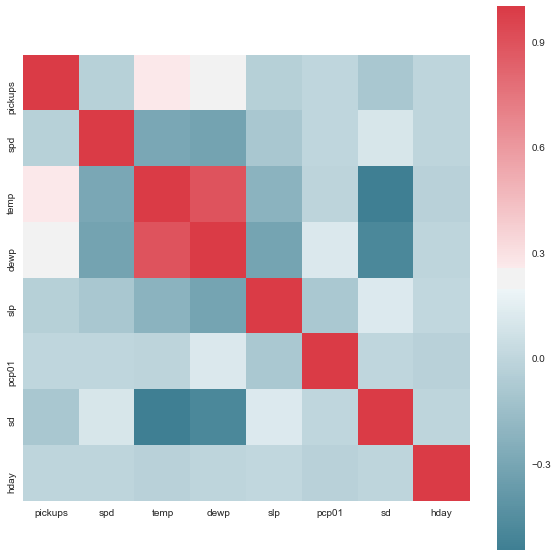

In [3]:
sns.set(style="white")
plt.figure(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(uber_df.corr(), square=True, cmap=cmap)
plt.show()

Most of the features show a roughly normal ditribution.  The major exceptions are one-hour precipitation and snow depth, which basically follow a Gamma distribution (which as I understand it is like a Poisson distribution, but for continuous processes).

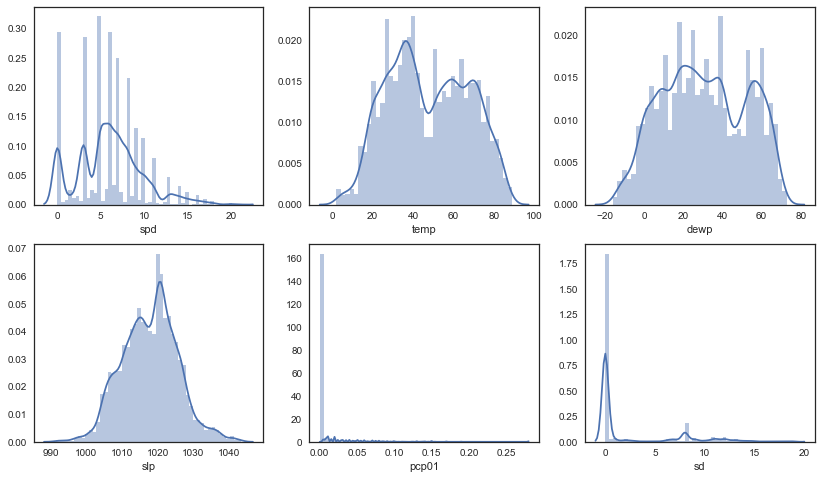

In [4]:
plt.figure(figsize=(14,8))
plt.subplot(231)
sns.distplot(uber_df["spd"])
plt.subplot(232)
sns.distplot(uber_df["temp"])
plt.subplot(233)
sns.distplot(uber_df["dewp"])
plt.subplot(234)
sns.distplot(uber_df["slp"])
plt.subplot(235)
sns.distplot(uber_df["pcp01"])
plt.subplot(236)
sns.distplot(uber_df["sd"])
plt.show()

# Feature engineering

Some features it would make sense to add:
<ul>
    <li><b>apparent temperature (app_temp): </b> the temperature it feels like outside.  Uses windchill formula for temperatures below 50F, humidex formula for temperatures over 70F, and a weighted blend in between.</li>
    <li><b>temperature extremity (temp_ext)</b> the absolute value of the z-score of the temperature.  Useful because it may have a linear relationship to people's willingness to walk rather than take an uber (people dislike very hot or very cold temperatures).</li>
    <li><b>hot humidity(hot_hum): </b> temp \* dewp.  People only dislike humidity when it's hot.  This feature captures the interaction between heat and humidity.</li>
    <li><b>windchill (windchill): </b> windchill according to the formula developed by the Joint Action Group for Temperature Indices (JAG/TI).  Depicts apparent temperature in Fahrenheit.</li>
    <li><b>humidex (humidex): </b> humidity index according to the formula developed by Canadian meteorologists.  Roughly depicts apparent temperature in Fahrenheit (normally, Celsius). </li>
    <li><b>hour of day (hour_of_day): </b> hours since 00:00:00, in even hours (dataset has no minutes).</li>
    <li><b>time extremity (time_ext): </b> distance (minutes) from nearest rush hour, defined as 9am and 6pm (I might consider changing formula for holidays).  Should capture the two-hump shape of total city traffic with the major weekday lull from roughly 10pm to 5am.  A more complex model would be needed to capture weekend and holiday deviations.</li>
    <li><b>wind-temperature-detriment (wind_tdet): </b> -(spd \* z-score(app_temp)).  Captures comfort detriment from the wind-temperature interaction: high wind with low z-score means high windchill and generates a high wind_tdet; high wind with high z-score means a cooling wind on a hot day and generates a negative wind_tdet.</li>
    <li><b>wind-precipitation-detriment (wind_pdet): </b> spd \* pcp01.  Captures comfort detriment from the wind-precipitation interaction: wind is always bothersome if it's raining, and may be neutral or pleasant if it's not.</li>
    <li><b>stormbrewing precipitation (storm_pcp): </b> slp \* pcp01.  Barometric pressure may affect walk-willingness differently depending on whether or not it's already raining.</li>
    <li><b>temp_leisure: </b> time_ext \* temp_ext.  Captures the effect that temperature comfortability may affect leisure trip frequency differently than work commutes.</li>
</ul>

In [4]:
# CREATE HELPER FUNCTIONS

# wind chill formula from Wikipedia (https://en.wikipedia.org/wiki/Wind_chill)
def windchill(temp, spd):
    # only really engineered to apply to temps below 50; we'll stretch to 60 for the purposes of apparent_temp
    if temp > 60:
        return temp
    
    return round( 35.74 + 0.6215*temp - 35.75*(spd**0.16) + 0.4275*temp*(spd**0.16), 1)

def humidex(temp, dewp):
    # only really engineered to apply to temps above 60
    if temp < 60:
        return temp
    
    # convert to Cels
    temp = (temp-32)*5/9
    dewp = (dewp-32)*5/9
    humidex = temp + 0.5555 * (6.11 * (math.exp(5417.7530*(1/273.15 - 1/(273.15+dewp)) ) ) - 10)
    # convert back to F
    humidex = humidex*9/5 + 32
    return round(humidex, 1)

def apparent_temp(temp, spd, dewp):

    if temp <= 50:
        wind_chill = windchill(temp, spd)
        app_temp =  wind_chill
    if 50 < temp <= 60:
        wind_chill = windchill(temp, spd)
        app_temp = (wind_chill*(60-temp) + temp*(temp-50)) / 10
    if 60 < temp <= 70:
        humi_dex = humidex(temp, dewp)
        app_temp = (humi_dex*((temp-60)) + temp*(70-temp)) / 10
    if temp > 70:
        humi_dex = humidex(temp, dewp)
        app_temp = humi_dex
    return round(app_temp, 1)

def time_ext(hour):
    return min(abs(9-hour), abs(18-hour), abs(18-(hour+24)))

In [5]:
# CREATE ACTUAL FEATURES
uber_df["app_temp"] = list(map( apparent_temp, uber_df["temp"], uber_df["spd"], uber_df["dewp"] ))
uber_df["hot_hum"] = uber_df["temp"] * uber_df["dewp"]
uber_df["windchill"] = list(map( windchill, uber_df["temp"], uber_df["spd"]))
uber_df["humidex"] = list(map( humidex, uber_df["temp"], uber_df["dewp"]))
uber_df["hour_of_day"] = uber_df["pickup_dt"].dt.hour
uber_df["time_ext"] = list(map(time_ext, uber_df["hour_of_day"]))
uber_df["temp_ext"] = abs(sp.stats.zscore(uber_df["app_temp"]))
uber_df["wind_tdet"] = -(uber_df["spd"] * sp.stats.zscore(uber_df["app_temp"]))
uber_df["wind_pdet"] = uber_df.spd * uber_df.pcp01
uber_df["storm_pcp"] = uber_df.slp * uber_df.pcp01
uber_df["temp_leisure"] = uber_df.temp_ext * uber_df.time_ext

uber_df.head()

,pickup_dt,borough,pickups,spd,temp,dewp,slp,pcp01,sd,hday,...,hot_hum,windchill,humidex,hour_of_day,time_ext,temp_ext,wind_tdet,wind_pdet,storm_pcp,temp_leisure
0,2015-01-01 01:00:00,Bronx,3.266102,5.0,30.0,7.0,1023.5,0.0,0.0,1,...,210.0,24.7,30.0,1,7,0.872807,4.364033,0.0,0.0,6.109646
1,2015-01-01 01:00:00,Brooklyn,3.340055,5.0,30.0,7.0,1023.5,0.0,0.0,1,...,210.0,24.7,30.0,1,7,0.872807,4.364033,0.0,0.0,6.109646
2,2015-01-01 01:00:00,EWR,-0.150242,5.0,30.0,7.0,1023.5,0.0,0.0,1,...,210.0,24.7,30.0,1,7,0.872807,4.364033,0.0,0.0,6.109646
3,2015-01-01 01:00:00,Manhattan,2.001135,5.0,30.0,7.0,1023.5,0.0,0.0,1,...,210.0,24.7,30.0,1,7,0.872807,4.364033,0.0,0.0,6.109646
4,2015-01-01 01:00:00,Queens,0.619662,5.0,30.0,7.0,1023.5,0.0,0.0,1,...,210.0,24.7,30.0,1,7,0.872807,4.364033,0.0,0.0,6.109646


# Feature Evaluation
Below, I've printed out the correlation matrix, sorted by absolute value of correlation with the target feature ("pickups").  As we can see, a lot of the top features are closely correlated with each other - which makes sense, given that half of them are combinations of temperature, humidity, and windspeed.

In [6]:
corrmat = uber_df.corr()
corrmat["abs_corr"] = abs(corrmat["pickups"])
corrmat = corrmat.sort_values("abs_corr", ascending=False)
corrmat

,pickups,spd,temp,dewp,slp,pcp01,sd,hday,app_temp,hot_hum,windchill,humidex,hour_of_day,time_ext,temp_ext,wind_tdet,wind_pdet,storm_pcp,temp_leisure,abs_corr
pickups,1.000000,-0.036152,0.264430,0.208263,-0.041457,0.000403,-0.094316,-0.007796,0.247538,0.250590,0.241678,0.264697,0.396117,-0.217662,0.096841,-0.208144,-0.002167,0.000658,-0.094772,1.000000
hour_of_day,0.396117,0.092416,0.093148,0.005703,-0.032343,-0.004163,-0.000215,0.001913,0.072604,0.042088,0.072547,0.081903,1.000000,-0.473118,0.047068,-0.079878,-0.008630,-0.004064,-0.293010,0.396117
humidex,0.264697,-0.301113,0.989601,0.916768,-0.227346,-0.002022,-0.525844,-0.021971,0.964286,0.962143,0.941792,1.000000,0.081903,0.005232,0.118208,-0.819989,-0.015906,-0.002162,0.072928,0.264697
temp,0.264430,-0.296126,1.000000,0.896544,-0.224537,-0.013343,-0.545558,-0.027764,0.962641,0.929193,0.956380,0.989601,0.093148,0.004943,0.032914,-0.836405,-0.022289,-0.013482,0.018503,0.264430
hot_hum,0.250590,-0.299572,0.929193,0.955994,-0.246191,0.047345,-0.473228,0.003127,0.915662,1.000000,0.877602,0.962143,0.042088,0.002249,0.246290,-0.747258,0.028433,0.047248,0.151898,0.250590
app_temp,0.247538,-0.440292,0.962641,0.885761,-0.195205,-0.003095,-0.501069,-0.032485,1.000000,0.915662,0.990740,0.964286,0.072604,-0.000186,0.009066,-0.872368,-0.031408,-0.003132,0.001547,0.247538
windchill,0.241678,-0.461466,0.956380,0.862918,-0.185796,-0.010076,-0.510439,-0.035786,0.990740,0.877602,1.000000,0.941792,0.072547,-0.001397,-0.073765,-0.877013,-0.035928,-0.010099,-0.051597,0.241678
time_ext,-0.217662,-0.007812,0.004943,0.008045,0.008123,0.015297,0.000180,-0.001604,-0.000186,0.002249,-0.001397,0.005232,-0.473118,1.000000,-0.023453,0.018434,0.025811,0.015516,0.663732,0.217662
dewp,0.208263,-0.321606,0.896544,1.000000,-0.311156,0.115399,-0.489372,-0.007857,0.885761,0.955994,0.862918,0.916768,0.005703,0.008045,0.031985,-0.760816,0.089878,0.115389,0.022401,0.208263
wind_tdet,-0.208144,0.434032,-0.836405,-0.760816,0.142406,-0.015156,0.437113,0.042243,-0.872368,-0.747258,-0.877013,-0.819989,-0.079878,0.018434,0.197086,1.000000,0.009829,-0.015226,0.153315,0.208144


Below I've written out a function to automatically select the top X features based on correlation with the target feature and nonredundancy with each other.

In [7]:
import pandas as pd

def corr_filter(df, target_feature, feature_count, maxcorr, return_corr=False):
    '''
    Args:
        df: the dataframe of features to be filtered (must include target 
            feature)
        target_feature(string): the feature that the other features are meant to 
            predict
        feature_count (int): the best X features to be returned (e.g., best 5)
        maxcorr (float): the correlation between features above which this 
            function will count one feature as redundant and drop it
        return_corr(Boolean): if true, function will also return a list of the 
            correlation-with-target-feature values of the returned features
    Returns: 
        list of the best X features, where "best" means most
        closely correlated with the target feature, excluding features
        that are redundant (corr > maxcorr) with better features
    '''
    # generate correlation matrix dataframe; sort by correlation strength
    corr_df = df.corr()
    corr_df["abs_corr"] = abs(corr_df[target_feature])
    corr_df = corr_df.sort_values("abs_corr", ascending=False)
    
    # go through each row and add to best features unless redundant until full
    best_features = []
    corrVals = []
    for index, row in corr_df.iterrows():
        # make sure we don't run the target feature against itself
        if index == target_feature:
            continue
        # check redundancy with already included features
        redundant = False
        for feature in best_features:
            if abs(row[feature]) > maxcorr:
                redundant = True
        if not redundant:
            best_features.append(index)
            corrVals.append(row[target_feature])
        
        # check to see if we're finished
        if len(best_features) == feature_count:
            break
    
    if len(best_features) < feature_count:
        print("There were fewer than {} features that met your redundancy criterion.".format(feature_count))
    if return_corr:
        return (best_features, corrVals)
    return best_features  

If we run this function (below), we get a list of the top features: hour of day, humidex, time extremity, wind detriment, and temperature extremity.  However, from manually examining the correlation matrix above, I can see that humidex and temperature are essentially identical in correlation.  So since temperature is the simpler of the two, I would swap out humidex for temperature (there's no sense having both since they're 99% correlated).

In [8]:
corr_filter(uber_df, "pickups", 5, .8, True)

(['hour_of_day', 'humidex', 'time_ext', 'temp_ext', 'temp_leisure'],
 [0.39611688816382723,
  0.2646973540965538,
  -0.21766173804936556,
  0.09684124858385823,
  -0.0947720864377128])

If we place a more stringent requirement for non-redundancy (corr < .4) on the selection function, we get a somewhat different result.

In [9]:
corr_filter(uber_df, "pickups", 5, .4, True)

(['hour_of_day', 'humidex', 'temp_ext', 'slp', 'spd'],
 [0.39611688816382723,
  0.2646973540965538,
  0.09684124858385823,
  -0.04145718152297811,
  -0.03615155861537662])

# Using PCA

Alternatively - or in conjunction - we could generate features using PCA.  In five principal components, PCA was able to capture about 80% of the total variance of the dataset.

In [10]:
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

In [40]:
pca_input = uber_df.iloc[:,3:].values
pca_input = StandardScaler().fit_transform(pca_input)

skpca = PCA(n_components=5)
pca_output = skpca.fit_transform(pca_input)

pc_df = pd.DataFrame(data=pca_output, columns=["pc1", "pc2", "pc3", "pc4", "pc5"])

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    skpca.explained_variance_ratio_)

pc_df.head()

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.38536019 0.1571322  0.11888273 0.07918547 0.06054972]


,pc1,pc2,pc3,pc4,pc5
0,2.180681,-0.58368,2.335775,-1.380921,-0.617232
1,2.180681,-0.58368,2.335775,-1.380921,-0.617232
2,2.180681,-0.58368,2.335775,-1.380921,-0.617232
3,2.180681,-0.58368,2.335775,-1.380921,-0.617232
4,2.180681,-0.58368,2.335775,-1.380921,-0.617232


We can now look at the combined dataset and see how well the principal component features correlate with other features (i.e., what sort of feature they're capturing about the time/weather), and how well they correlate with our target feature of pickups.

In [28]:
pc_pickups_df = pd.concat((uber_df.loc[:,"pickups"], pc_df), axis=1)
corrmat2 = pc_pickups_df.corr()
corrmat2["abs_corr"] = abs(corrmat2["pickups"])
corrmat2.sort_values("abs_corr", ascending=False).index

corrmat2["pickups"]

pickups    1.000000
pc1       -0.194763
pc2        0.017040
pc3        0.062547
pc4        0.042935
pc5       -0.036124
Name: pickups, dtype: float64

Interestingly, only one or two of our PCA features cracks the top five, depending on how we set the redundancy criteriion.  This may mean that much of the predictive power of the non-pca features comes from their overlap with each other.

<b>This raises a question:</b> how could we test this?  Could we test the goodness of the top five filtered original features against the top five pca features by subtracting the total correlation of each of the original features?  Specifically: for the first original feature, subtract its correlation with the other four from its correlation with the target; for the second original feature, subtract its correlation with features 3-5 from its correlation with the target, etc.  Then compare that total to the PCA total (which has no inter-feature correlation to cancel out).  Would this work?

In [41]:
joint_df = pd.concat((uber_df.iloc[:,2:], pc_df), axis=1)
print(corr_filter(joint_df, "pickups", 5, .8, True))
print(corr_filter(joint_df, "pickups", 5, .4, True))

(['hour_of_day', 'humidex', 'time_ext', 'pc1', 'temp_ext'], [0.39611688816382723, 0.2646973540965538, -0.21766173804936556, -0.19476304024325647, 0.09684124858385823])
(['hour_of_day', 'humidex', 'temp_ext', 'pc3', 'pc4'], [0.39611688816382723, 0.2646973540965538, 0.09684124858385823, 0.06254720369970479, 0.04293546669312333])


As an experiment, we can also see what each principal component is capturing by looking at the features it correlates with. 

In [44]:
joint_df = pd.concat((uber_df.iloc[:,2:], pc_df), axis=1)
corrmat = joint_df.corr()
chart_df = pd.DataFrame()

corrmat["abs_corr"] = abs(corrmat["pc1"])
chart_df["pc1"] = corrmat.sort_values("abs_corr", ascending=False).index

corrmat["abs_corr"] = abs(corrmat["pc2"])
chart_df["pc2"] = corrmat.sort_values("abs_corr", ascending=False).index

corrmat["abs_corr"] = abs(corrmat["pc3"])
chart_df["pc3"] = corrmat.sort_values("abs_corr", ascending=False).index

corrmat["abs_corr"] = abs(corrmat["pc4"])
chart_df["pc4"] = corrmat.sort_values("abs_corr", ascending=False).index

corrmat["abs_corr"] = abs(corrmat["pc5"])
chart_df["pc5"] = corrmat.sort_values("abs_corr", ascending=False).index
# corrmat["abs_corr"] = abs(corrmat["pc3"])
# corrmat.sort_values("abs_corr", ascending=False)["pc3"]

chart_df

,pc1,pc2,pc3,pc4,pc5
0,pc1,pc2,pc3,pc4,pc5
1,temp,temp_leisure,temp_ext,temp_ext,temp_ext
2,humidex,hday,hot_hum,temp_leisure,sd
3,app_temp,temp_ext,temp_leisure,hot_hum,temp_leisure
4,windchill,time_ext,humidex,slp,hday
5,hot_hum,temp,dewp,dewp,windchill
6,dewp,windchill,pickups,humidex,temp
7,wind_tdet,spd,hday,spd,dewp
8,sd,sd,slp,hday,wind_tdet
9,spd,app_temp,temp,temp,app_temp


From this chart, it looks like the first feature is something like apparent temperature, using temperature, wind, humidity, and metrics that combine those three.  The second feature is more capturing the time aspects of the dataset.  The next three are harder to distinguish, all relying on temperature extremity as the most correlated feature.